# Global & local vertical scale estimation

## Summary

Process results of progressive hypsometry (PH) for a collection of regions and their ensemble of "supercatchments" to identify the global and local vertical scales of each. 

Each supercatchments PH data file provides a set of $h_\mathrm{outlet}$ and $h_\mathrm{bench}$ values in tab-separated form. This table of PHBs (progressive hypsometry benches) is converted into an vector of $\Delta{h} = h_\mathrm{bench}-h_\mathrm{outlet}$ values.

Kernel density estimation is used to compute a smooth frequency distribution (pdf) of $\Delta{h}$ assuming a Gaussian kernel with a Silverman bandwidth (narrowed by 75%).

The peaks of this distribution, which are the modes of the pdf, are located, and the largest two, which likely constitute the global and local vertical scales, are chosen.

The kde pdf is then modeled through least-squares curve-fitting using two Gaussians, whose means are initiated at these two modes respectively, and whose means, standard deviations and relative magnitude are permitted to vary.

The result is an estimate of the global and local scales and their spread (one standard deviation) for each supercatchment. These results are gathered into one summary table and exported as a text file.

Graphs are plotted to record the kde pdf, the Gaussian-modeled pdf, the raw kde pdf modes and the Gaussian modeled modes aka global and local vertical scales.

### Prerequisites

To run this notebook you’ll need to have installed (with `Conda`, `pip` or other package manager) the following packages:
  - numpy
  - scipy
  - matplotlib
  - os
  - pandas
  - sklearn
  - json

### How to run

1. Open a terminal
2. Assuming you are running `bash`, type: 
    - `export PHHOME="${HOME}/Science/ProgHypso"` 
    - or whatever your path to the parent for `PHscales` is
3. `cd` to the directory containing the notebook
4. Type `jupyter-notebook`, or to choose a specific version, e.g.  `jupyter-notebook-3.7`
5. `Cell` -> `Run all`

## Parameters

In [1]:
phbs_groups = [
    ['Ac0p1km2','PHBs','Cusum02_BenchLength3Steps','Tables'],
    ['Ac0p5km2','PHBs','Cusum02_BenchLength3Steps','Tables'] 
]
example_phb_index = 0

In [2]:
# bandwidth_adjustment_factor = 0.75
bandwidth_adjustment_factor = 1
bandwidth_adjustment_factor
default_gaussian_stdev = 20

1

## Preliminaries

In [3]:
import json, os, pandas as pd, numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.neighbors.kde import KernelDensity
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.stats import norm

In [4]:
ph_home_path=os.getenv('PHHOME',
                os.path.join(os.getenv('HOME'),'Science','ProgHypso'))
if ph_home_path is None:
    ph_home_path=os.path.join(os.getenv('HOME'),'Science','ProgHypso')
ph_scales_path = os.path.join(ph_home_path,'PHscales')

In [5]:
# figsize = [6, 8]
figsize = [8, 6]
mpl.rc( 'figure', autolayout=False,  titlesize='Large',dpi=100)
mpl.rc( 'lines', linewidth=2.0, markersize=8)
mpl.rc( 'font', size=12, family='Arial')
mpl.rc( 'axes', labelsize=12) 

## Methods

In [6]:
def read_data(dir_name=('.'), file_name=None, 
              file_ext='', key='ph', sep='\t',
              index_col=0, header=0, skip_rows=None):
    """
    """
    dir_name = os.path.join(*dir_name)
    if not os.path.exists(dir_name):
        print('Cannot find data directory')
        raise
    try:
        file_path = os.path.join(dir_name,file_name+file_ext)
        df = pd.read_csv(file_path, sep=sep,
                           index_col=index_col, header=header, 
                           skiprows=skip_rows) 
    except OSError:  
        print('Cannot read data file {}'.format(file_path))
        raise
    except:  
        raise
    return df

In [7]:
def bimodal_model(x,x0,s0,a0,x1,s1):
    return ( a0*norm.pdf(x, loc=x0,scale=s0)
            +(1-a0)*norm.pdf(x, loc=x1,scale=s1) )

In [8]:
def trimodal_model(x,x0,s0,a0,x1,s1,a1,x2,s2):
    return ( a0*norm.pdf(x, loc=x0,scale=s0)
            +a1*norm.pdf(x, loc=x1,scale=s1)
            +(1-a0-a1)*norm.pdf(x, loc=x2,scale=s2) )

In [9]:
def compute_kde_pdf(phbs_dict, phb):
    raw_df = phbs_dict[phb]['raw_df']
    data = np.array(raw_df['Delta_h']).reshape(-1,1)
    Delta_h_array = np.linspace(0,1.2*np.max(data),200)
    bw = data.std()*(4/3/data.size)**(1/5)*bandwidth_adjustment_factor
    print('{}:  bandwidth = {:.0f}'.format(phb,bw))
    kde = KernelDensity(kernel='gaussian', bandwidth=bw)
    kde.fit(data)
    kde_array = np.exp(kde.score_samples(Delta_h_array.reshape(-1,1)))
    kde_df = pd.DataFrame(index=None,
                          data={'Delta_h': Delta_h_array,
                                'p_Delta_h': kde_array})
    phbs_dict[phb].update({'kde_df':kde_df})

In [10]:
def find_modes(phbs_dict, phb):
    kde_df = phbs_dict[phb]['kde_df']
    Delta_h_array = kde_df['Delta_h']
    p_Delta_h_array = kde_df['p_Delta_h']
    peaks_array = find_peaks(p_Delta_h_array)[0]
    peaks_array = np.vstack((peaks_array,
                             Delta_h_array[peaks_array],
                             p_Delta_h_array[peaks_array])).T
    # Sort by magnitude (largest p(∆h) first)
    peaks_array = np.flipud(peaks_array[peaks_array[:,2].argsort()])
    principal_modes_array = peaks_array[:,1:3]
    phbs_dict[phb].update({'modes':principal_modes_array})

    print(phb)
    print('Principal mode#1: ∆h={:.0f}m  p(∆h)={:.5f}'
          .format(principal_modes_array[0,0],principal_modes_array[0,1]))
    print('Principal mode#2: ∆h={:.0f}m  p(∆h)={:.5f}'
          .format(principal_modes_array[1,0],principal_modes_array[1,1]))
    if principal_modes_array.shape[0]>2:
        print('Principal mode#3: ∆h={:.0f}m  p(∆h)={:.5f}'
          .format(principal_modes_array[2,0],principal_modes_array[2,1]))
    print('')

In [11]:
def fit_bimodal(phbs_dict, phb):
    kde_df          = phbs_dict[phb]['kde_df']
    modes_array     = phbs_dict[phb]['modes']
    Delta_h_array   = kde_df['Delta_h']
    p_Delta_h_array = kde_df['p_Delta_h']
    initial_values  = [modes_array[0,0], default_gaussian_stdev, 0.5,
                       modes_array[1,0], default_gaussian_stdev]
    popt,pcov = curve_fit(bimodal_model, 
                          Delta_h_array, p_Delta_h_array, 
                          p0=initial_values)
    scales_array = np.zeros((2,8))
    scales_array[0,:] = [popt[0],popt[1],
                         bimodal_model(popt[0],*popt),
                         *popt]
    scales_array[1,:] = [popt[3],popt[4],
                         bimodal_model(popt[3],*popt),
                         *popt]
    scales_array = np.flipud(scales_array[scales_array[:,0].argsort()])
    phbs_dict[phb].update({'bimodal_scales': scales_array})
    
    print(phb)
#     print(modes_array)
    print('Global vertical scale: H_G = {:.0f} ± {:.0f}m  p(∆h)={:0.5f}'
          .format(*list(scales_array[0,:])))
    print('Local vertical scale:  H_L = {:.0f} ± {:.0f}m  p(∆h)={:0.5f}'
          .format(*list(scales_array[1,:])))
    print()

In [12]:
def fit_trimodal(phbs_dict, phb):
    kde_df          = phbs_dict[phb]['kde_df']
    modes_array     = phbs_dict[phb]['modes']
    Delta_h_array   = kde_df['Delta_h']
    p_Delta_h_array = kde_df['p_Delta_h']
    if modes_array.shape[0]>2:
        initial_values  = [modes_array[0,0], default_gaussian_stdev, 0.5,
                           modes_array[1,0], default_gaussian_stdev, 0.4,
                           modes_array[2,0], default_gaussian_stdev]
        popt,pcov = curve_fit(trimodal_model, 
                              Delta_h_array, p_Delta_h_array, 
                              p0=initial_values)

        scales_array = np.zeros((3,3))
        scales_array[0,:] = [popt[0],popt[1],popt[2]]
        scales_array[1,:] = [popt[3],popt[4],popt[5]]
        scales_array[2,:] = [popt[6],popt[7],1.0-popt[2]-popt[5]]
        scales_array=np.flipud(scales_array[scales_array[:,0].argsort()])
        phbs_dict[phb].update({'trimodal_scales': scales_array})
        
        print(phb)
#         print(modes_array)
        print('Global vertical scale: H_G = {:.0f} ± {:.0f}m'
              .format(scales_array[0,0],scales_array[0,1]))
        print('Local vertical scale:  H_L = {:.0f} ± {:.0f}m'
              .format(scales_array[1,0],scales_array[1,1]))
        print('Extra vertical scale:  H_X = {:.0f} ± {:.0f}m'
              .format(scales_array[2,0],scales_array[2,1]))
        print()
    else:
        print(phb)
        print('Two modes only resolved')
        print()
        phbs_dict[phb].update({'trimodal':(None,None)})

## Graphics

In [13]:
def plot_pdf(phbs_dict, phb):
    kde_df          = phbs_dict[phb]['kde_df']
    modes_array     = phbs_dict[phb]['modes']
    Delta_h_array   = kde_df['Delta_h']
    p_Delta_h_array = kde_df['p_Delta_h']
    bimodal_scales_array  = phbs_dict[phb]['bimodal_scales']
    print(bimodal_scales_array)
#     trimodal_scales_array = phbs_dict[phb]['trimodal_scales']

    figure = plt.figure(figsize=figsize)
    plt.plot(Delta_h_array,p_Delta_h_array, 
             c='DarkGreen', lw=1,
             label='kde pdf')
    plt.plot(bimodal_scales_array[0,0],bimodal_scales_array[0,2],
             'o',ms=8,c='DarkGreen',fillstyle='none')
    plt.plot(bimodal_scales_array[1,0],bimodal_scales_array[1,2],
             's',ms=8,c='DarkGreen',fillstyle='none')
#     plt.plot(principal_modes_array[1,0],principal_modes_array[1,1],
#              's',ms=8,c='DarkGreen',fillstyle='none')
#     plt.plot(Delta_h_array, bimodal_model(Delta_h_array, *popt),
#              c='DarkBlue',lw=2,
#              label='dual Gaussian fit')
#     plt.plot(popt[0],bimodal_model(popt[0], *popt),
#              'o',ms=6,c='DarkBlue',
#              label=r'global scale  $H_G \approx ${}$\pm${}m'\
#                  .format(int(np.round(popt[0])),int(np.round(popt[1])) ))
#     plt.plot(popt[3],bimodal_model(popt[3], *popt),
#              's',ms=6,c='DarkBlue',
#              label=r' local scale   $H_L \approx ${}$\pm${}m'\
#                  .format(int(np.round(popt[3])),int(np.round(popt[4])) ))
    axes = plt.gca()
    axes.set_ylim(0,)
#     axes.set_xlim(0,1.2*np.max(ph_df['Delta_h']));
#     if popt[0]>np.max(ph_df['Delta_h'])/2:
#         loc='upper left'
#     else:
#         loc='upper right'
#     plt.legend(fontsize=12,loc=loc)
#     plt.title(data_set_name);

## Data

In [14]:
region_dict = {}
for dir in os.listdir(ph_scales_path):
    path = os.path.realpath(os.path.join(ph_scales_path,dir))
    if dir[0]!='.' and dir!='Analysis' and os.path.isdir(path):
        region_dict.update({dir : path})
region_dict 

{'CostaRica': '/Users/colinstark/Science/ProgHypso/PHscales/CostaRica',
 'Finisterres': '/Users/colinstark/Science/ProgHypso/PHscales/Finisterres',
 'GabilanMesa': '/Users/colinstark/Science/ProgHypso/PHscales/GabilanMesa',
 'SanGabriel': '/Users/colinstark/Science/ProgHypso/PHscales/SanGabriel',
 'SantaMarta': '/Users/colinstark/Science/ProgHypso/PHscales/SantaMarta'}

In [15]:
supercatchment_dict = {}
for phbs_group in phbs_groups:
    for region in region_dict:
        path = os.path.join(region_dict[region],*phbs_group)
        if os.path.isdir(path):
            supercatchment_list = [
                (path,supercatchment)
                for supercatchment in os.listdir(path) 
                if supercatchment[0]!='.']
            supercatchment_dict.update({region : supercatchment_list})
supercatchment_dict

{'SanGabriel': [('/Users/colinstark/Science/ProgHypso/PHscales/SanGabriel/Ac0p1km2/PHBs/Cusum02_BenchLength3Steps/Tables',
   'Supercatchment132_allOutletModePairs.txt')],
 'CostaRica': [('/Users/colinstark/Science/ProgHypso/PHscales/CostaRica/Ac0p5km2/PHBs/Cusum02_BenchLength3Steps/Tables',
   'Supercatchment11_allOutletModePairs.txt'),
  ('/Users/colinstark/Science/ProgHypso/PHscales/CostaRica/Ac0p5km2/PHBs/Cusum02_BenchLength3Steps/Tables',
   'Supercatchment16_allOutletModePairs.txt'),
  ('/Users/colinstark/Science/ProgHypso/PHscales/CostaRica/Ac0p5km2/PHBs/Cusum02_BenchLength3Steps/Tables',
   'Supercatchment19_allOutletModePairs.txt'),
  ('/Users/colinstark/Science/ProgHypso/PHscales/CostaRica/Ac0p5km2/PHBs/Cusum02_BenchLength3Steps/Tables',
   'Supercatchment1_allOutletModePairs.txt'),
  ('/Users/colinstark/Science/ProgHypso/PHscales/CostaRica/Ac0p5km2/PHBs/Cusum02_BenchLength3Steps/Tables',
   'Supercatchment24_allOutletModePairs.txt'),
  ('/Users/colinstark/Science/ProgHypso/P

In [16]:
phbs_dict = {}

In [17]:
for supercatchment in supercatchment_dict.keys():
    for phbs in supercatchment_dict[supercatchment]:
        name = supercatchment+'_'+phbs[1].replace('.txt','')
        path = (phbs[0],phbs[1])
        df = read_data(dir_name=[phbs[0]], 
                          file_name=phbs[1], index_col=None)
        phbs_dict.update({name : {'path':phbs[0],
                                  'file':phbs[1],
                                  'raw_df':  df} })

list(phbs_dict.keys())

['SanGabriel_Supercatchment132_allOutletModePairs',
 'CostaRica_Supercatchment11_allOutletModePairs',
 'CostaRica_Supercatchment16_allOutletModePairs',
 'CostaRica_Supercatchment19_allOutletModePairs',
 'CostaRica_Supercatchment1_allOutletModePairs',
 'CostaRica_Supercatchment24_allOutletModePairs',
 'CostaRica_Supercatchment30_allOutletModePairs',
 'CostaRica_Supercatchment9_allOutletModePairs',
 'Finisterres_Supercatchment12_allOutletModePairs',
 'Finisterres_Supercatchment18_allOutletModePairs',
 'Finisterres_Supercatchment33_allOutletModePairs',
 'Finisterres_Supercatchment37_allOutletModePairs',
 'GabilanMesa_Supercatchment1_allOutletModePairs',
 'GabilanMesa_Supercatchment2_allOutletModePairs',
 'SantaMarta_Supercatchment19_allOutletModePairs']

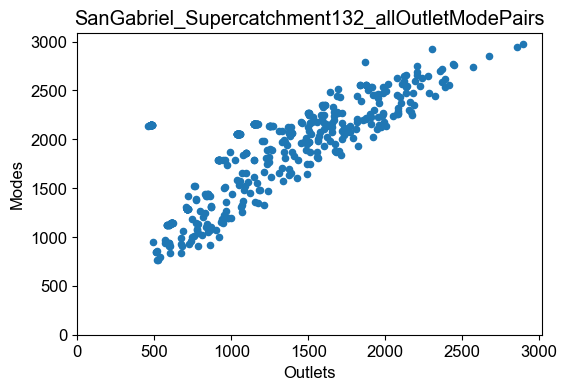

In [18]:
example_phb = list(phbs_dict.keys())[example_phb_index]
df = phbs_dict[example_phb]['raw_df']
axes = df.plot.scatter(x='Outlets',y='Modes',title=example_phb)
axes.set_xlim(0,);
axes.set_ylim(0,);

## Analysis

For every supercatchment result table (now in a `pandas` dataframe), compute $\Delta{h} = h_\mathrm{mode}-h_\mathrm{outlet}$ and put into a new column in that dataframe.

In [19]:
for phb in phbs_dict:
    df = phbs_dict[phb]['raw_df']
    df['Delta_h'] = df['Modes']-df['Outlets']

Check the pdf $p(\Delta{h})$ for an example super.

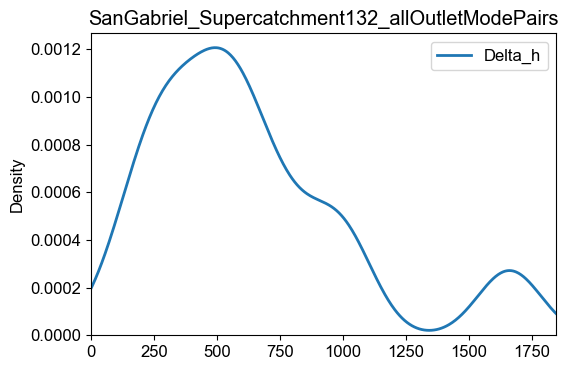

In [20]:
example_phb = list(phbs_dict.keys())[example_phb_index]

df = phbs_dict[example_phb]['raw_df']
axes = df.plot.density(x='Outlets',y='Delta_h',bw_method='silverman',
                          title=example_phb)
axes.set_xlim(0,1.1*np.max(df['Delta_h']));
axes.set_ylim(0,);

Compute a kernel-density estimated pdf for each super, and place in another dataframe for each.

In [21]:
for phb in phbs_dict:
    compute_kde_pdf(phbs_dict, phb)

SanGabriel_Supercatchment132_allOutletModePairs:  bandwidth = 125
CostaRica_Supercatchment11_allOutletModePairs:  bandwidth = 88
CostaRica_Supercatchment16_allOutletModePairs:  bandwidth = 166
CostaRica_Supercatchment19_allOutletModePairs:  bandwidth = 135
CostaRica_Supercatchment1_allOutletModePairs:  bandwidth = 110
CostaRica_Supercatchment24_allOutletModePairs:  bandwidth = 89
CostaRica_Supercatchment30_allOutletModePairs:  bandwidth = 123
CostaRica_Supercatchment9_allOutletModePairs:  bandwidth = 127
Finisterres_Supercatchment12_allOutletModePairs:  bandwidth = 103
Finisterres_Supercatchment18_allOutletModePairs:  bandwidth = 138
Finisterres_Supercatchment33_allOutletModePairs:  bandwidth = 159
Finisterres_Supercatchment37_allOutletModePairs:  bandwidth = 135
GabilanMesa_Supercatchment1_allOutletModePairs:  bandwidth = 22
GabilanMesa_Supercatchment2_allOutletModePairs:  bandwidth = 25
SantaMarta_Supercatchment19_allOutletModePairs:  bandwidth = 95


For the example super, compare this kde pdf with the one generated and plotted above by `pandas`.

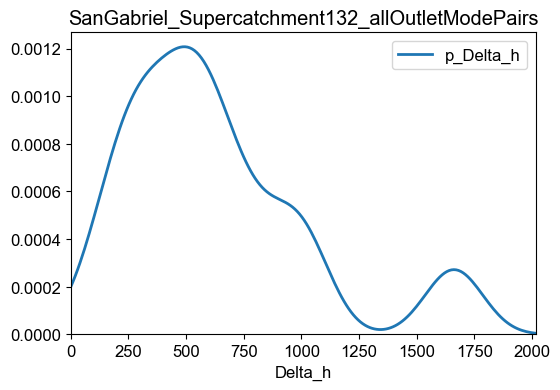

In [22]:
example_phb = list(phbs_dict.keys())[example_phb_index]
df = phbs_dict[example_phb]['kde_df']
axes = df.plot.line(x='Delta_h',y='p_Delta_h',
                          title=example_phb)
axes.set_xlim(0,np.max(df['Delta_h']));
axes.set_ylim(0,);

In [23]:
for phb in phbs_dict:
    modes = find_modes(phbs_dict, phb)

SanGabriel_Supercatchment132_allOutletModePairs
Principal mode#1: ∆h=496m  p(∆h)=0.00121
Principal mode#2: ∆h=1661m  p(∆h)=0.00027

CostaRica_Supercatchment11_allOutletModePairs
Principal mode#1: ∆h=652m  p(∆h)=0.00147
Principal mode#2: ∆h=248m  p(∆h)=0.00109
Principal mode#3: ∆h=1205m  p(∆h)=0.00071

CostaRica_Supercatchment16_allOutletModePairs
Principal mode#1: ∆h=292m  p(∆h)=0.00086
Principal mode#2: ∆h=2091m  p(∆h)=0.00045
Principal mode#3: ∆h=1458m  p(∆h)=0.00038

CostaRica_Supercatchment19_allOutletModePairs
Principal mode#1: ∆h=358m  p(∆h)=0.00132
Principal mode#2: ∆h=1652m  p(∆h)=0.00038
Principal mode#3: ∆h=1035m  p(∆h)=0.00020

CostaRica_Supercatchment1_allOutletModePairs
Principal mode#1: ∆h=992m  p(∆h)=0.00113
Principal mode#2: ∆h=270m  p(∆h)=0.00093

CostaRica_Supercatchment24_allOutletModePairs
Principal mode#1: ∆h=358m  p(∆h)=0.00173
Principal mode#2: ∆h=1120m  p(∆h)=0.00050
Principal mode#3: ∆h=889m  p(∆h)=0.00039

CostaRica_Supercatchment30_allOutletModePairs
Principa

In [24]:
for phb in phbs_dict:
    fit_bimodal(phbs_dict, phb)

SanGabriel_Supercatchment132_allOutletModePairs
Global vertical scale: H_G = 1665 ± 111m  p(∆h)=0.00026
Local vertical scale:  H_L = 497 ± 318m  p(∆h)=0.00117

CostaRica_Supercatchment11_allOutletModePairs
Global vertical scale: H_G = 661 ± 60m  p(∆h)=0.00146
Local vertical scale:  H_L = 423 ± 392m  p(∆h)=0.00091

CostaRica_Supercatchment16_allOutletModePairs
Global vertical scale: H_G = 1656 ± 608m  p(∆h)=0.00030
Local vertical scale:  H_L = 332 ± 269m  p(∆h)=0.00082

CostaRica_Supercatchment19_allOutletModePairs
Global vertical scale: H_G = 1637 ± 160m  p(∆h)=0.00035
Local vertical scale:  H_L = 372 ± 260m  p(∆h)=0.00132

CostaRica_Supercatchment1_allOutletModePairs
Global vertical scale: H_G = 1011 ± 153m  p(∆h)=0.00107
Local vertical scale:  H_L = 366 ± 262m  p(∆h)=0.00092

CostaRica_Supercatchment24_allOutletModePairs
Global vertical scale: H_G = 1052 ± 294m  p(∆h)=0.00043
Local vertical scale:  H_L = 320 ± 165m  p(∆h)=0.00168

CostaRica_Supercatchment30_allOutletModePairs
Global 

In [25]:
for phb in phbs_dict:
    fit_trimodal(phbs_dict, phb)

SanGabriel_Supercatchment132_allOutletModePairs
Two modes only resolved

CostaRica_Supercatchment11_allOutletModePairs
Global vertical scale: H_G = 1205 ± 101m
Local vertical scale:  H_L = 657 ± 115m
Extra vertical scale:  H_X = 261 ± 155m

CostaRica_Supercatchment16_allOutletModePairs
Global vertical scale: H_G = 2105 ± 145m
Local vertical scale:  H_L = 1410 ± 291m
Extra vertical scale:  H_X = 349 ± 298m

CostaRica_Supercatchment19_allOutletModePairs
Global vertical scale: H_G = 1648 ± 132m
Local vertical scale:  H_L = 1094 ± 154m
Extra vertical scale:  H_X = 369 ± 242m

CostaRica_Supercatchment1_allOutletModePairs
Two modes only resolved

CostaRica_Supercatchment24_allOutletModePairs
Global vertical scale: H_G = 1121 ± 56m
Local vertical scale:  H_L = 1021 ± 348m
Extra vertical scale:  H_X = 317 ± 162m

CostaRica_Supercatchment30_allOutletModePairs
Two modes only resolved

CostaRica_Supercatchment9_allOutletModePairs
Global vertical scale: H_G = 2000 ± 133m
Local vertical scale:  H_L

## Plotting

[[1.66543909e+03 1.10849134e+02 2.61144362e-04 4.97135155e+02
  3.17613053e+02 9.27812462e-01 1.66543909e+03 1.10849134e+02]
 [4.97135155e+02 3.17613053e+02 1.16539171e-03 4.97135155e+02
  3.17613053e+02 9.27812462e-01 1.66543909e+03 1.10849134e+02]]


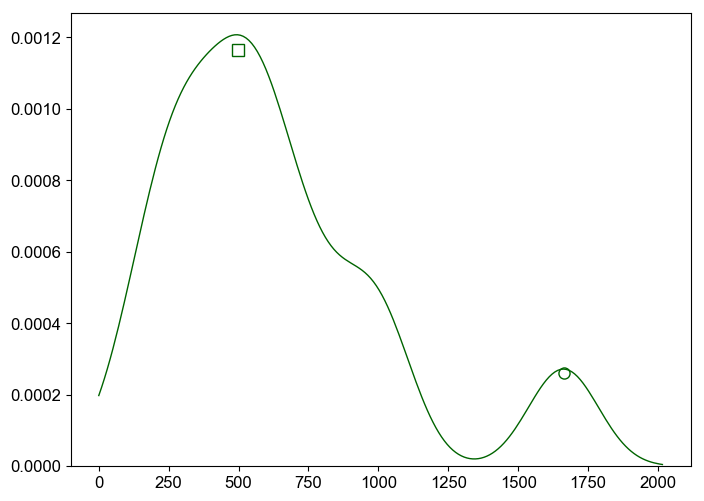

In [26]:
example_phb = list(phbs_dict.keys())[example_phb_index]
plot_pdf(phbs_dict,example_phb)

## Export